In [18]:
from datetime import datetime
import numpy as np

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from nltk.sentiment import SentimentIntensityAnalyzer
from easynmt import EasyNMT
from tqdm import tqdm
import translators as ts
import json


In [22]:
df = pd.read_csv('data.csv', sep=',').head(10000)
translator = google_translator(url_suffix="cz")  
df['ContentEn'] = trans(df)
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x[:9], '%d-%b-%y'))
df.drop(['Author', 'Attachments', 'Reactions'], axis='columns', inplace=True)
#df.to_csv('new_data.csv')
df.head()

,AuthorID,Date,Content,ContentEn
0,231280990339858433,2020-10-07,"proč n může být 0, ale složky vektůrku jsou až...","Why can n be 0, but the vectors are up to 1?"
1,231280990339858433,2020-10-07,"< 👨 , 👩 > je lineární obal - tedy prostor (asi...",429 Client Error: Too Many Requests for url: h...
2,495184340511096852,2020-10-07,co myslis tou sumou?,429 Client Error: Too Many Requests for url: h...
3,458594303346999306,2020-10-07,"> < 👨 , 👩 > je lineární obal - tedy prostor (a...","> <👨, 👩> is the linear cover - that is, the sp..."
4,725810198496936059,2020-10-07,Všichni dohromady se milují.,They all love each other.


In [18]:
from multiprocessing.dummy import Pool as ThreadPool
import time

 # Threads
def request(text):
    lang = "en"
    try:
        translate_text = ts.server.google(text, from_language='cs', to_language='en')
    except Exception as e:
        translate_text = str(e)
    return translate_text

def trans(df):
    pool = ThreadPool(4)
    texts = list(df['Content'])
    try:
        results = pool.map(request, texts)
    except Exception as e:
        raise e
    pool.close()
    pool.join()
    return results

In [26]:
df_new = pd.read_csv('new_data.csv', sep=',')
sia = SentimentIntensityAnalyzer()
df_new['ContentEn'] =  df_new['ContentEn'].astype(str)
df_new['Pol'] = df_new['ContentEn'].apply(lambda x: sia.polarity_scores(x))
df_new['CompoundPol'] = df_new['Pol'].apply(lambda x: x['compound'])
df_new.to_csv('new_data_pol.csv')
df_new.head()

,Unnamed: 0,AuthorID,Date,Content,ContentEn,Pol,CompoundPol
0,0,231280990339858433,2020-10-07,"proč n může být 0, ale složky vektůrku jsou až...","Why can n be 0, but the vectors are up to 1?","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,1,231280990339858433,2020-10-07,"< 👨 , 👩 > je lineární obal - tedy prostor (asi...",429 Client Error: Too Many Requests for url: h...,"{'neg': 0.252, 'neu': 0.748, 'pos': 0.0, 'comp...",-0.4019
2,2,495184340511096852,2020-10-07,co myslis tou sumou?,429 Client Error: Too Many Requests for url: h...,"{'neg': 0.252, 'neu': 0.748, 'pos': 0.0, 'comp...",-0.4019
3,3,458594303346999306,2020-10-07,"> < 👨 , 👩 > je lineární obal - tedy prostor (a...","> <👨, 👩> is the linear cover - that is, the sp...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,4,725810198496936059,2020-10-07,Všichni dohromady se milují.,They all love each other.,"{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'comp...",0.6369


In [19]:
#importy
from tsplot import tsplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import matplotlib.pylab as plt
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))

In [21]:
# DATA PREPARATION (Takes about 10 minutes, so I converted final dataset to csv slack_data_pol.csv
sia = SentimentIntensityAnalyzer()
df = pd.read_csv('slack_data.csv', sep=',')
df = df[['sent', 'text']]
df['text'] = df['text'].astype(str)

df['sent'] = df['sent'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
df['pol'] = df['text'].apply(lambda x: sia.polarity_scores(x))
df.to_csv('slack_data_pol_full.csv')
df['CompoundPol'] = df['pol'].apply(lambda x: x['compound'])
df = df[['sent', 'CompoundPol']]
df = df.groupby(['sent']).mean()
df.to_csv('slack_data_pol.csv')

C:\Users\Tomiu\AppData\Local\Temp\ipykernel_16240\4254843760.py:3: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('slack_data.csv', sep=',')


,CompoundPol
sent,
2014-12-31,0.157531
2015-01-01,0.278917
2015-01-02,0.233815
2015-01-03,0.220433
2015-01-04,0.219815


,CompoundPol
sent,
2017-12-05,0.103440
2017-12-06,0.092410
2017-12-07,0.090051
2017-12-08,0.085668
2017-12-09,0.118941


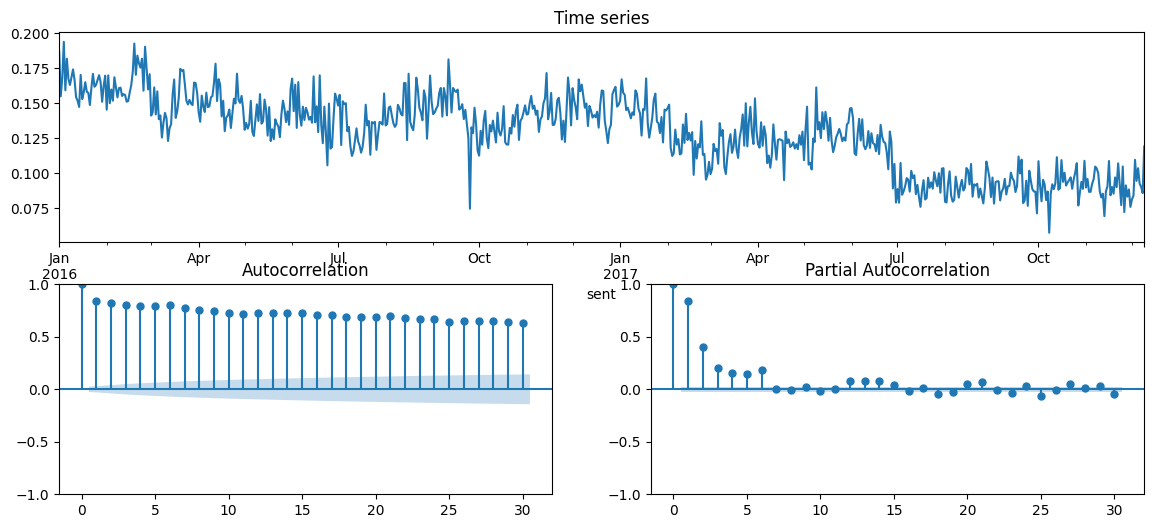

In [12]:
df = pd.read_csv('slack_data_pol.csv', sep=',', index_col=0, parse_dates=True, infer_datetime_format=True)
display(df.head())
display(df.tail(5))
df['CompoundPol'] = df['CompoundPol'].astype(float)
df = df['CompoundPol'].last('2Y')
df = df.asfreq('D', 'bfill')
tsplot(df, lags=30)

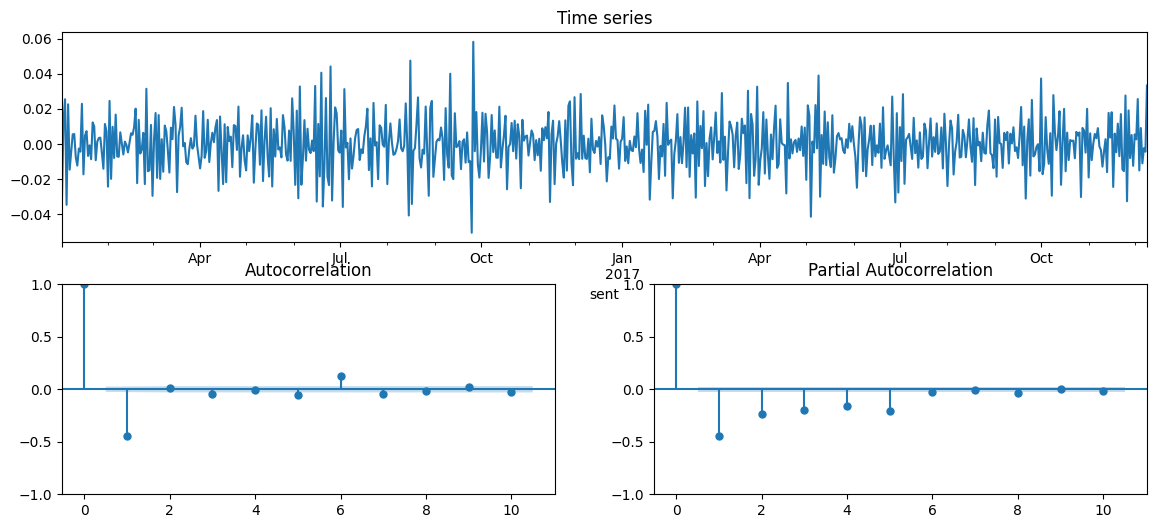

In [6]:
df_detrend = df.diff().dropna()
tsplot(df_detrend, lags=10)

In [7]:
arma_order_select_ic(df_detrend, ic='aic', trend='c')

w:\diploma_thesis\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
w:\diploma_thesis\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
w:\diploma_thesis\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
w:\diploma_thesis\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
w:\diploma_thesis\venv\lib\site-packages\statsmodels\base\model.py:604: C

{'aic':              0            1            2
 0 -3974.312791 -4242.116740 -4244.465483
 1 -4131.251020 -4245.342125 -4243.393543
 2 -4170.868413 -4245.202109 -4231.153760
 3 -4195.948554 -4239.330969 -4234.201792
 4 -4213.728874 -4241.441738 -4232.478368,
 'aic_min_order': (1, 1)}

                               SARIMAX Results                                
Dep. Variable:            CompoundPol   No. Observations:                  709
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2126.089
Date:                Wed, 07 Dec 2022   AIC                          -4246.179
Time:                        17:11:12   BIC                          -4232.491
Sample:                    01-01-2016   HQIC                         -4240.891
                         - 12-09-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1195      0.047      2.521      0.012       0.027       0.212
ma.L1         -0.8059      0.028    -28.668      0.000      -0.861      -0.751
sigma2         0.0001   6.41e-06     22.480      0.0

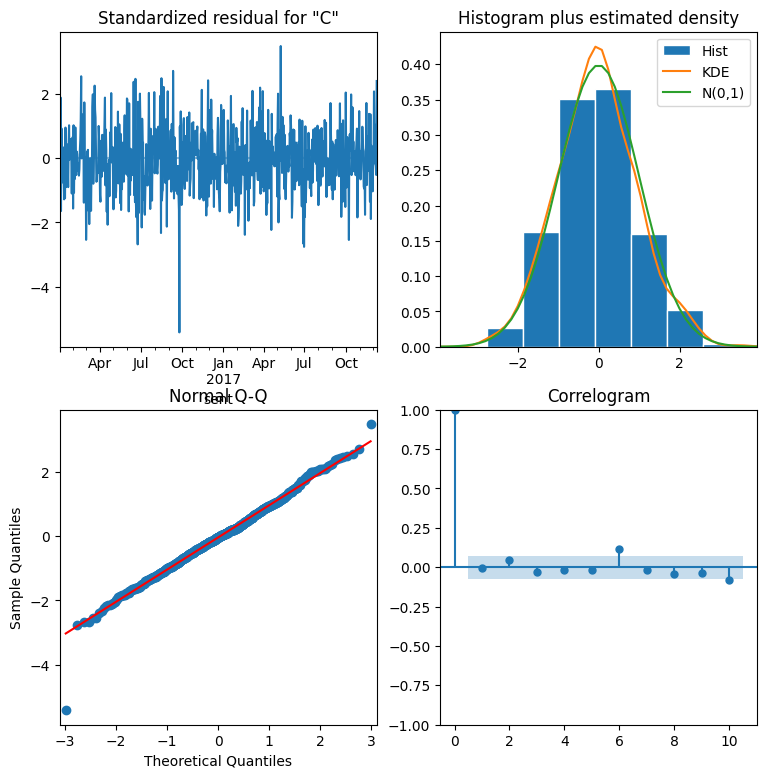

In [9]:
model = ARIMA(df, order=(1,1,1), trend='n')
res = model.fit()
print(res.summary())
res.plot_diagnostics(figsize=(9,9))
plt.show()

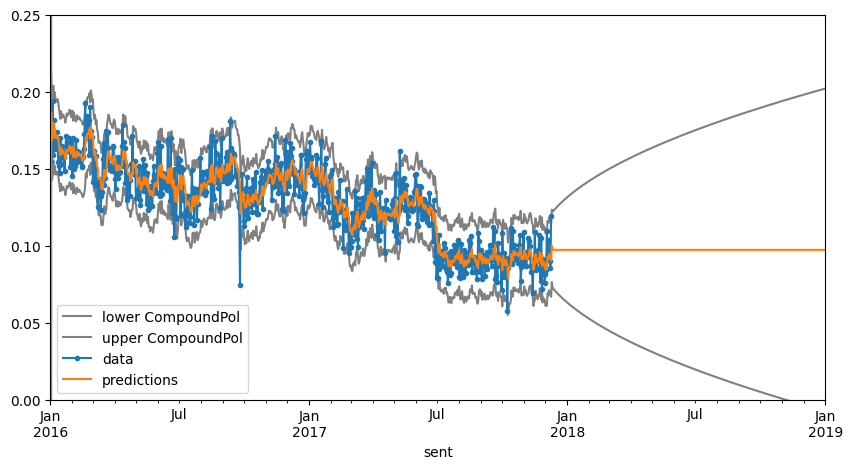

In [17]:
preds = res.get_prediction(end='2019-01-01')
ci = preds.conf_int()
fig = ci.plot(color='grey', figsize=(10, 5))
res.data.orig_endog.plot(label='data', marker='.', fig=fig)
preds.predicted_mean.plot(label='predictions', fig=fig)
plt.ylim(0, 0.25)
plt.legend()
plt.show()